In [3]:
# Download elevation data
!wget http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_26_19.zip

--2020-03-30 21:31:11--  http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/TIFF/srtm_26_19.zip
Resolving srtm.csi.cgiar.org (srtm.csi.cgiar.org)...45.5.184.44
Connecting to srtm.csi.cgiar.org (srtm.csi.cgiar.org)|45.5.184.44|:80...connected.
HTTP request sent, awaiting response...301 Moved Permanently
Location: http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/tiff/srtm_26_19.zip [following]
--2020-03-30 21:31:11--  http://srtm.csi.cgiar.org/wp-content/uploads/files/srtm_5x5/tiff/srtm_26_19.zip
Reusing existing connection to srtm.csi.cgiar.org:80.
HTTP request sent, awaiting response...200 OK
Length: 15182395 (14M) [application/x-zip-compressed]
Saving to: ‘srtm_26_19.zip.1’

srtm_26_19.zip.1    100%[===================>]  14,48M   550KB/s    in 34s     

2020-03-30 21:31:45 (442 KB/s) - ‘srtm_26_19.zip.1’ saved [15182395/15182395]



In [4]:
# Unzip
!unzip srtm_26_19

Archive:  srtm_26_19.zip
  inflating: readme.txt              
  inflating: srtm_26_19.hdr          
  inflating: srtm_26_19.tfw          
  inflating: srtm_26_19.tif


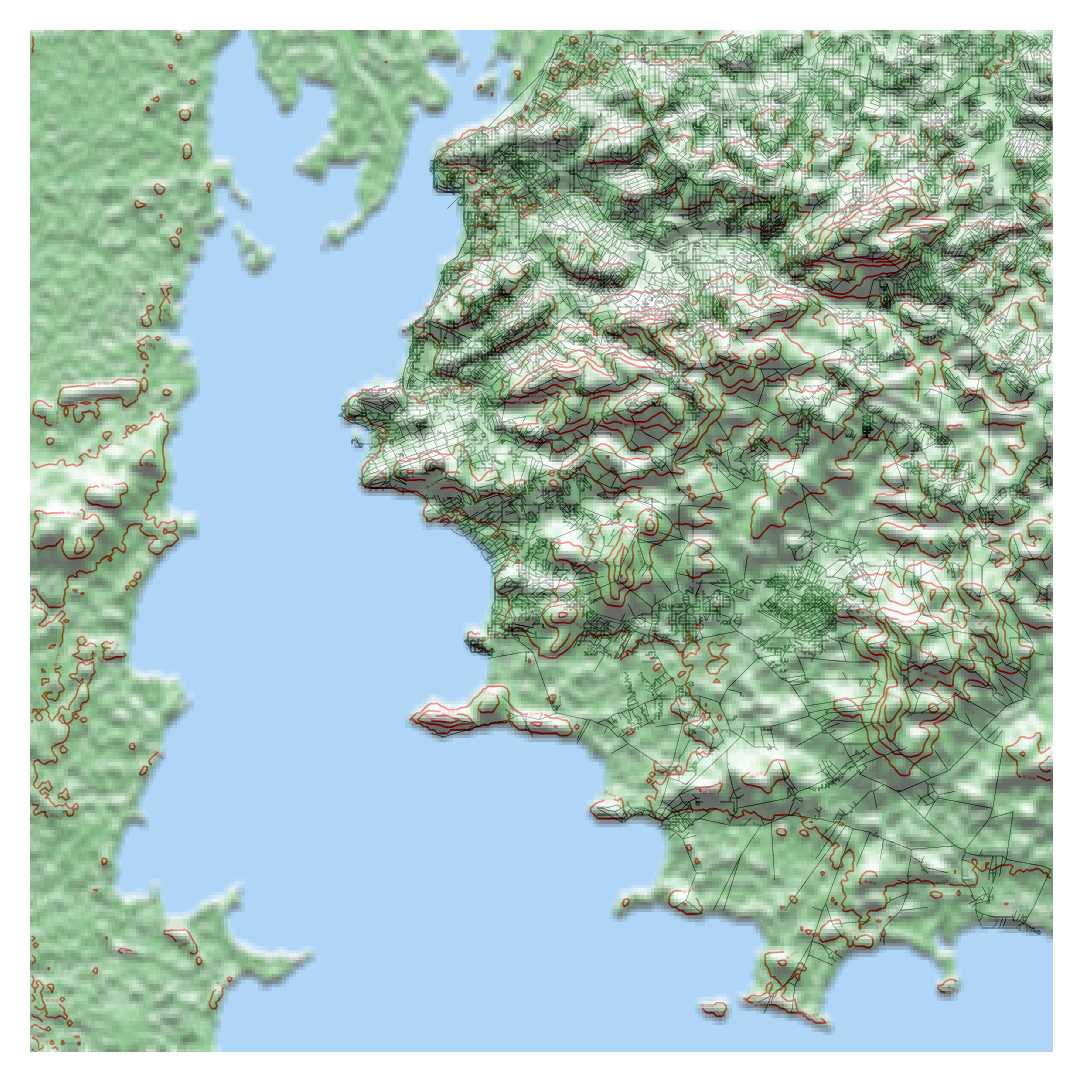

In [2]:
import cv2
import rasterio
import osmnx as ox
import numpy as np
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import pyplot as plt
from scipy.interpolate import interp2d
from matplotlib.colors import hex2color
from matplotlib.collections import LineCollection

# Setup figure
fig, ax = plt.subplots(dpi=300)
plt.tight_layout()
ax.set_aspect('equal')
plt.axis('off')

# Set bounding box
lon_bounds, lat_bounds = [-51.35, -50.8], [-30.55, -30.]
lon_bounds[-1] = np.mean(lon_bounds)
lat_bounds[0] = np.mean(lat_bounds)

# Read elevation data
elevation_dataset = rasterio.open('srtm_26_19/srtm_26_19.tif')

# Create NxN numpy matrix with elevation data
N = 300
i, j = elevation_dataset.index(
    np.linspace(*lon_bounds, N),
    np.linspace(*lat_bounds, N)
)
elevation = elevation_dataset.read(1)[np.meshgrid(i, j)]

# Interpolate to increase resolution
f = interp2d(
    np.linspace(0, 1, N),
    np.linspace(0, 1, N),
    elevation, kind='linear'
)
N *= 1
elevation = f(
    np.linspace(0, 1, N),
    np.linspace(0, 1, N)
)

# Rotate matrix to align with north
elevation = np.rot90(elevation)

# Download street network graph
g = ox.graph_from_bbox(*lat_bounds[::-1], *lon_bounds[::-1])

# Map from GPS to pixel coordinates
def gps_to_pixel(lon, lat):
    i = int(N*(lat-lat_bounds[0])/(lat_bounds[1]-lat_bounds[0]))
    j = int(N*(lon-lon_bounds[0])/(lon_bounds[1]-lon_bounds[0]))
    return j, N-i

# Plot street network
lines = []
for n1, n2, _ in list(g.edges):
    i1, j1 = gps_to_pixel(g.nodes[n1]['x'], g.nodes[n1]['y'])
    i2, j2 = gps_to_pixel(g.nodes[n2]['x'], g.nodes[n2]['y'])
    lines.append([(i1, j1), (i2, j2)])
lc = LineCollection(lines, colors='black', linewidths=.1, zorder=2)
ax.add_collection(lc)

# Plot contour lines
CS = ax.contour(
    range(N), range(N), elevation,
    np.arange(10, 300, 50), linewidths=.4, colors='red', zorder=1
)
ax.clabel(CS, fontsize=0)

# Map elevations <0 to blue (water) and >0 to green (terrain)
terrain_map = elevation.copy()
terrain_map[elevation < 0] = 0
terrain_map[elevation >= 0] = 1
cmap = colors.ListedColormap(np.array([
    hex2color('#7ABAF2'),
    hex2color('#43A047')
]))
terrain_map = cmap(terrain_map)

# Create shading from elevation data and blend with terrain map
light = colors.LightSource(azdeg=0, altdeg=0)
shading = light.shade_rgb(terrain_map, elevation)

# Blur shading to smooth square edges
shading = cv2.blur(shading, (3, 3))

# Plot shading
ax.imshow(shading, cmap='gray', alpha=.6, zorder=3)

# Save and show
plt.savefig('poa-map.png')
plt.show()